In [10]:
from numpy import *
from matplotlib.pyplot import *

from crnpy.colors import cyan,yellow
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage import zoom

from get_bifurcations import get_bifurcations
from scipy.interpolate import UnivariateSpline,interp1d

from crnpy.parser import fromcrn
from crnpy.colors import cyan,yellow,cyanyellow
from matplotlib.pyplot import *

from numpy import *
from scipy.interpolate import interp2d
from json import loads,dumps

from os import system
from os.path import isfile
from re import finditer,sub,search

from matplotlib.pyplot import *
from numpy import *
from scipy.interpolate import interp2d

from numpy.random import normal
from scipy.interpolate import UnivariateSpline

%matplotlib inline

In [11]:
moving = genfromtxt('c6-10-c12-40.csv',dtype=float,delimiter=',').reshape(97,2,20)
stationary = genfromtxt('c6-125-c12-40.csv',dtype=float,delimiter=',').reshape(97,2,20)

moving = transpose(moving.reshape(97,2,20),axes=(0,2,1))
stationary = transpose(stationary.reshape(97,2,20),axes=(0,2,1))

moving = gradient(moving,axis=0)
stationary = gradient(stationary,axis=0)

# moving[moving < 0] = 0
# stationary[stationary < 0] = 0

ntime,nspace,_ = moving.shape
space = linspace(0,5,nspace)
time = linspace(0,48,ntime)

space,time = meshgrid(space,time)

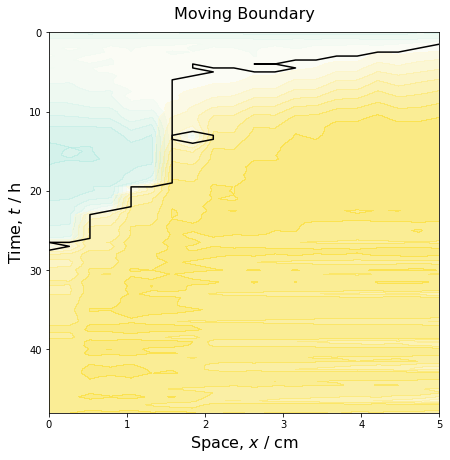

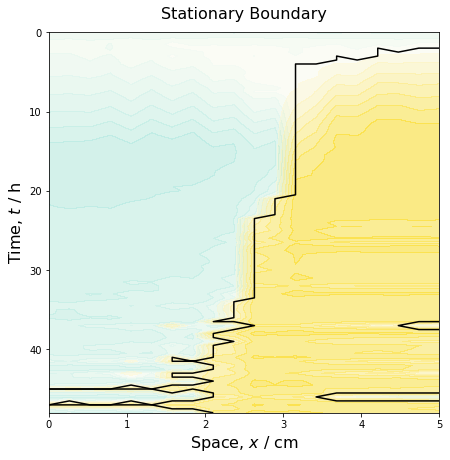

In [12]:
figure(figsize=(7,7))
title('Moving Boundary',fontsize=16,y=1.02)

m = (moving[:,:,0]-moving[:,:,1])
m[m<0] = 0
contourf(space,time,log10(m+1),cmap='cyan',alpha=0.5)

contour(space,time,log10(m+1),levels=[0.0],colors=['k'])

m = (moving[:,:,0]-moving[:,:,1])
m[m>0] = 0
m*=-1
contourf(space,time,log10(m+5),cmap='yellow',alpha=0.5)

gca().invert_yaxis()
xlabel(r'Space, $x$ / cm',fontsize=16)
ylabel(r'Time, $t$ / h',fontsize=16);


figure(figsize=(7,7))
title('Stationary Boundary',fontsize=16,y=1.02)

s = (stationary[:,:,0])-(stationary[:,:,1])
s[s<0] = 0
contourf(space,time,log10(s+1),cmap='cyan',alpha=0.5,origin='upper')

contour(space,time,log10(s+1),levels=[0.0],colors=['k'])

s = (stationary[:,:,0])-(stationary[:,:,1])
s[s>0] = 0; s*=-1
contourf(space,time,log10(s+5),cmap='yellow',alpha=0.5,origin='upper')


gca().invert_yaxis()
xlabel(r'Space, $x$ / cm',fontsize=16)
ylabel(r'Time, $t$ / h',fontsize=16);

 [parser] ignoring directive simulator 
 [model]  non-spatial directive


<Figure size 1080x360 with 0 Axes>

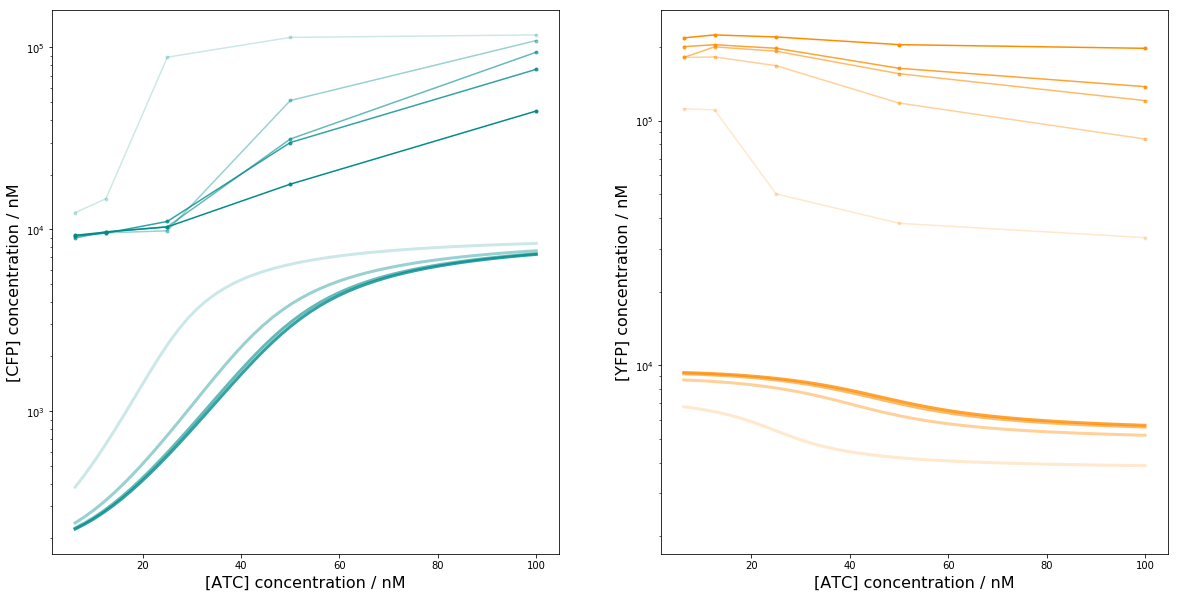

In [34]:
crn_path = 'double-exclusive.crn'
# import model from file
model = fromcrn(crn_path)

C6,C12,ATC,IPTG,CFP,YFP = genfromtxt('atc-iptg-data.csv',
                                     delimiter=',',dtype=float,skip_header=1).T

ratio = (CFP-YFP)/(CFP+YFP)
derepressor_ratio = (ATC-IPTG)/(ATC+IPTG)
sort_index = argsort(derepressor_ratio)

ratio = ratio[sort_index]
derepressor_ratio = derepressor_ratio[sort_index]

YFP = YFP[sort_index]; CFP = CFP[sort_index];
C6 = C6[sort_index]; C12 = C12[sort_index]
ATC = ATC[sort_index]; IPTG = IPTG[sort_index]

ratio = ratio.reshape(-1,5)
derepressor_ratio = derepressor_ratio.reshape(-1,5)

YFP = YFP.reshape(-1,5); CFP = CFP.reshape(-1,5)
C6 = C6.reshape(-1,5); C12 = C12.reshape(-1,5)
ATC = ATC.reshape(-1,5); IPTG = IPTG.reshape(-1,5)

# ATC = 45*ATC/amax(ATC)
# IPTG = 0.275*IPTG/amax(IPTG)

figure(figsize=(15,5))

yfp = array([ yfp[argsort(c12)] for c12,yfp in zip(C12[:5],YFP[:5]) ])
cfp = array([ cfp[argsort(c12)] for c12,cfp in zip(C12[:5],CFP[:5]) ])

# plot(ATC[:5],yfp,'.-')
alpha = 0.2
i = 0
c12 = unique(C12[:5])

fig = figure(figsize=(20,10));
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

for a,y,c in zip(ATC[:5].T,yfp.T,cfp.T) :

    ax1.plot(a,c,'.-',color='darkcyan',alpha=alpha,label=r'$C_{12}=$ '+str(c12[i])+' nM')
    ax2.plot(a,y,'.-',color='darkorange',alpha=alpha)
    alpha += 0.2
    i += 1

ax1.set_xlabel('[ATC] concentration / nM',fontsize=16)
ax1.set_ylabel('[CFP] concentration / nM',fontsize=16)
ax1.set_yscale('log')

K = 50
N = 5
iptg = mean(IPTG[:5])
atc_grid = linspace(amin(ATC[:5]),amax(ATC[:5]),K)
cfp = zeros((atc_grid.size,N))
yfp = zeros((atc_grid.size,N))


for i,atc in enumerate(atc_grid) :

    model.ATC = atc
    model.IPTG = iptg

    c6 = array([10000., 10000., 10000., 10000., 10000.])
    c12 = array([   16.,    80.,   400.,  2000., 10000.])

    c_grid = dstack([c6,c12])

    # calculation of steady states
    steady_state = model.get_steady_state(c_grid,logspace=True)
    cfp[i] = steady_state[:,:,model.nontrivials.index('cfp')]
    yfp[i] = steady_state[:,:,model.nontrivials.index('yfp')]


alpha=0
i=0
for c,y in zip(cfp.T,yfp.T) :
    ax1.plot(atc_grid,c,linewidth=3,
         color='darkcyan',alpha=alpha)

    ax2.plot(atc_grid,y,linewidth=3,
         color='darkorange',alpha=alpha)

    alpha += 0.2
    i += 1
    

ax2.set_xlabel('[ATC] concentration / nM',fontsize=16)
ax2.set_ylabel('[YFP] concentration / nM',fontsize=16)
ax2.set_yscale('log');

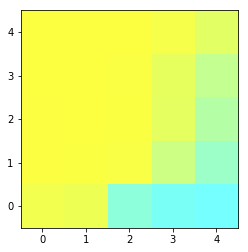

In [5]:

imshow(-(cfp.T-yfp.T)/(cfp.T+yfp.T),cmap='cyanyellow',origin='bottom',alpha=0.75)
# imshow(yfp.T,cmap='yellow',origin='bottom',alpha=0.75)

<Figure size 1080x360 with 0 Axes>

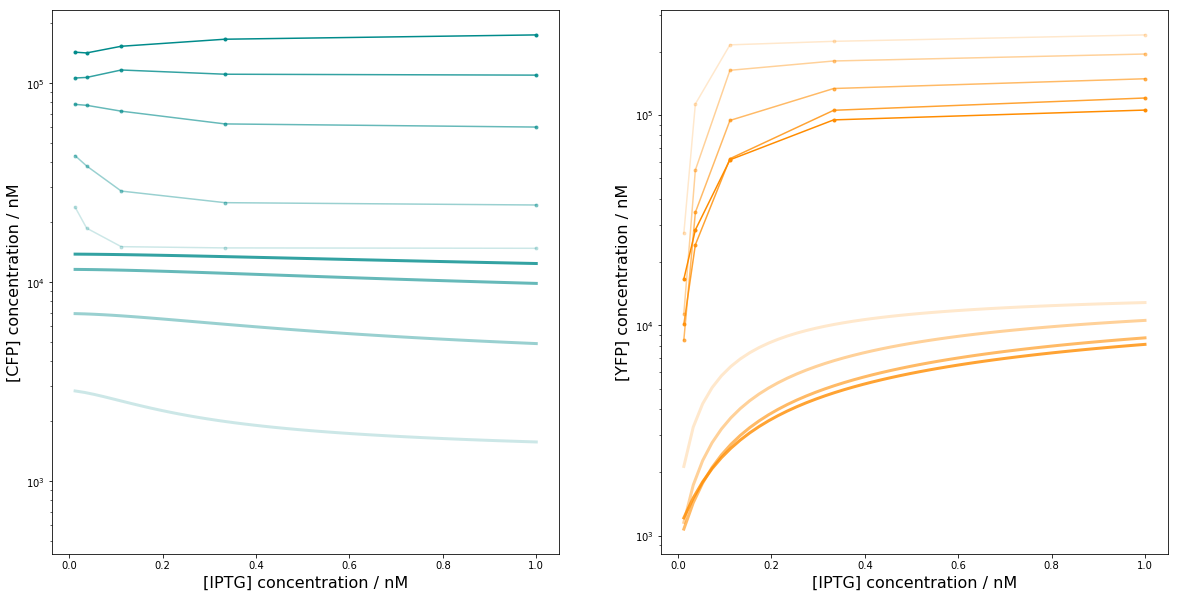

In [27]:
C6,C12,ATC,IPTG,CFP,YFP = genfromtxt('proc_R33S175ExrepTet33AAVLac300ND_IPTGATC_titration.csv',
                                     delimiter=',',dtype=float,skip_header=1).T

ratio = (CFP-YFP)/(CFP+YFP)
derepressor_ratio = -(ATC-IPTG)/(ATC+IPTG)
sort_index = argsort(derepressor_ratio)

ratio = ratio[sort_index]
derepressor_ratio = derepressor_ratio[sort_index]

YFP = YFP[sort_index]; CFP = CFP[sort_index];
C6 = C6[sort_index]; C12 = C12[sort_index]
ATC = ATC[sort_index]; IPTG = IPTG[sort_index]

ratio = ratio.reshape(-1,5)
derepressor_ratio = derepressor_ratio.reshape(-1,5)

YFP = YFP.reshape(-1,5); CFP = CFP.reshape(-1,5)
C6 = C6.reshape(-1,5); C12 = C12.reshape(-1,5)
ATC = ATC.reshape(-1,5); IPTG = IPTG.reshape(-1,5)

figure(figsize=(15,5))

yfp = array([ yfp[argsort(c6)] for c6,yfp in zip(C6[:5],YFP[:5]) ])
cfp = array([ cfp[argsort(c6)] for c6,cfp in zip(C6[:5],CFP[:5]) ])

# plot(ATC[:5],yfp,'.-')
alpha = 0.2
i = 0
c6 = unique(C6[:5])

fig = figure(figsize=(20,10));
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

for a,y,c in zip(IPTG[:5].T,yfp.T,cfp.T) :

    ax1.plot(a,c,'.-',color='darkcyan',alpha=alpha,label=r'$C_{12}=$ '+str(c12[i])+' nM')
    ax2.plot(a,y,'.-',color='darkorange',alpha=alpha)
    alpha += 0.2
    i += 1

ax1.set_xlabel('[IPTG] concentration / nM',fontsize=16)
ax1.set_ylabel('[CFP] concentration / nM',fontsize=16)
ax1.set_yscale('log')

K = 50
N = 5
atc = mean(ATC[:5])
iptg_grid = linspace(amin(IPTG[:5]),amax(IPTG[:5]),K)
cfp = zeros((iptg_grid.size,N))
yfp = zeros((iptg_grid.size,N))


for i,iptg in enumerate(iptg_grid) :

    model.ATC = atc
    model.IPTG = iptg

    c12 = array([10000., 10000., 10000., 10000., 10000.])
    c6 = array([   16.,    80.,   400.,  2000., 10000.])

    c_grid = dstack([c6,c12])

    # calculation of steady states
    steady_state = model.get_steady_state(c_grid,logspace=True)
    cfp[i] = steady_state[:,:,model.nontrivials.index('cfp')]
    yfp[i] = steady_state[:,:,model.nontrivials.index('yfp')]


alpha=0
i=0
for c,y in zip(cfp.T,yfp.T) :
    ax1.plot(iptg_grid,c,linewidth=3,
         color='darkcyan',alpha=alpha)

    ax2.plot(iptg_grid,y,linewidth=3,
         color='darkorange',alpha=alpha)

    alpha += 0.2
    i += 1


ax2.set_xlabel('[IPTG] concentration / nM',fontsize=16)
ax2.set_ylabel('[YFP] concentration / nM',fontsize=16)
ax2.set_yscale('log');

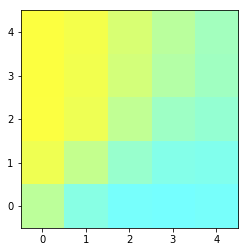

In [8]:
imshow(-(cfp-yfp)/(cfp+yfp),cmap='cyanyellow',origin='bottom',alpha=0.75)


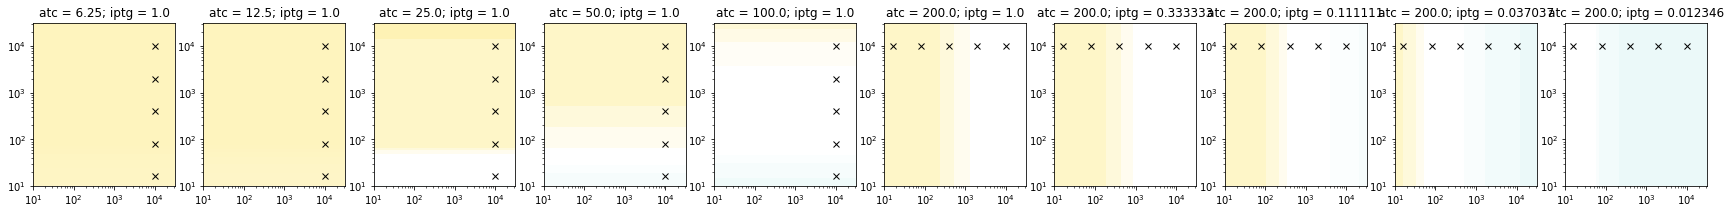

In [31]:
from scipy.interpolate import griddata


f, ax_arr = subplots(1,10, figsize=(30,3))
xx = logspace(1,4.5,5)
grid_x, grid_y = meshgrid(xx,xx)

i = 0
for c6,c12,r,atc,iptg in zip(C6,C12,ratio,ATC,IPTG) :

    points = array([c6,c12]).T
    values = r


    grid_z0 = griddata(points, values, (grid_x, grid_y), method='nearest')

    ax_arr[i].set_title('atc = {}; iptg = {}'.format(mean(atc),mean(iptg)))
    ax_arr[i].plot(*points.T,'kx')
    
    zz = array(grid_z0)
    zz[zz<0] = 0
    ax_arr[i].contourf(grid_x,grid_y,log(zz+0.1),cmap='cyan',vmin=-1,vmax=1,alpha=0.5)
    
    zz = array(grid_z0)
    zz[zz>0] = 0; zz *= -1
    ax_arr[i].contourf(grid_x,grid_y,log(zz+0.1),cmap='yellow',vmin=-1,vmax=1,alpha=0.5)

    ax_arr[i].set_xscale('log')
    ax_arr[i].set_yscale('log')
    i += 1

Text(0.5, 0, 'image number')

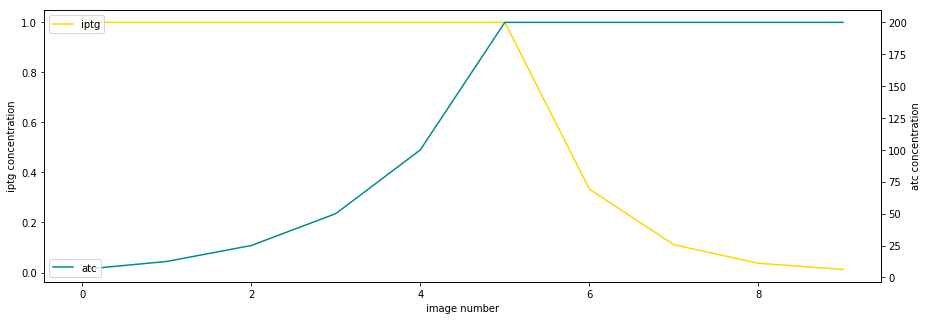

In [32]:
fig, ax1 = subplots(figsize=(15,5))
ax2 = ax1.twinx()

ax1.plot(IPTG.T[0],'gold',label='iptg')
ax1.legend(loc=2)
ax1.set_ylabel('iptg concentration')
ax2.plot(ATC.T[0],'darkcyan',label='atc')
ax2.legend(loc=3)
ax2.set_ylabel('atc concentration')
ax1.set_xlabel('image number')


In [28]:
crn_path = 'double-exclusive.crn'
# import model from file
model = fromcrn(crn_path)


 [parser] ignoring directive simulator 
 [model]  non-spatial directive


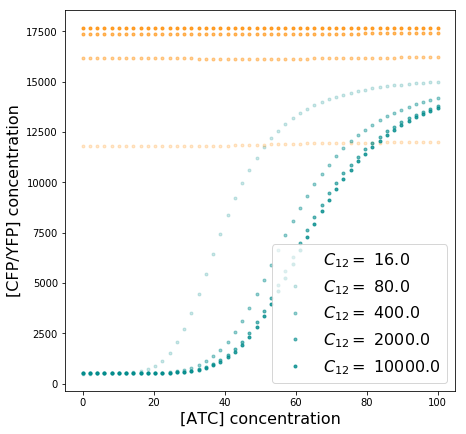

In [198]:
K = 50
N = 5
iptg = 100.0
atc_grid = linspace(0,100,K)
cfp = zeros((atc_grid.size,N))
yfp = zeros((atc_grid.size,N))

for i,atc in enumerate(atc_grid) :

    model.ATC = atc
    model.IPTG = iptg

    c6 = array([10000., 10000., 10000., 10000., 10000.])
    c12 = array([   16.,    80.,   400.,  2000., 10000.])
    c_grid = dstack([c6,c12])

    # calculation of steady states
    steady_state = model.get_steady_state(c_grid,logspace=True)
    cfp[i] = steady_state[:,:,model.nontrivials.index('cfp')]
    yfp[i] = steady_state[:,:,model.nontrivials.index('yfp')]
    
figure(figsize=(7,7))
alpha=0
i=0
for c,y in zip(cfp.T,yfp.T) :
    plot(atc_grid,c,'.',
         color='darkcyan',alpha=alpha,
         label=r'$C_{12}=$ '+str(c12[i]))
    
    plot(atc_grid,y,'.',
         color='darkorange',alpha=alpha)
    
    alpha += 0.2
    i += 1
    

xlabel('[ATC] concentration',fontsize=16)
ylabel('[CFP/YFP] concentration',fontsize=16)
legend(fontsize=16);

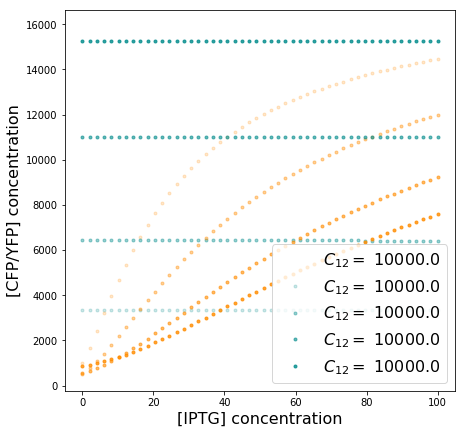

In [199]:
K = 50
N = 5
iptg_grid = linspace(0,1,K)
atc = 200
cfp = zeros((iptg_grid.size,N))
yfp = zeros((iptg_grid.size,N))

for i,iptg in enumerate(iptg_grid) :

    model.ATC = atc
    model.IPTG = iptg

    c12 = array([10000., 10000., 10000., 10000., 10000.])
    c6 = array([   16.,    80.,   400.,  2000., 10000.])
    c_grid = dstack([c6,c12])

    # calculation of steady states
    steady_state = model.get_steady_state(c_grid,logspace=True)
    cfp[i] = steady_state[:,:,model.nontrivials.index('cfp')]
    yfp[i] = steady_state[:,:,model.nontrivials.index('yfp')]
    
figure(figsize=(7,7))
alpha=0
i=0
for c,y in zip(cfp.T,yfp.T) :
    plot(atc_grid,c,'.',
         color='darkcyan',alpha=alpha,
         label=r'$C_{12}=$ '+str(c12[i]))
    
    plot(atc_grid,y,'.',
         color='darkorange',alpha=alpha)
    
    alpha += 0.2
    i += 1
    

xlabel('[IPTG] concentration',fontsize=16)
ylabel('[CFP/YFP] concentration',fontsize=16)
legend(fontsize=16);